In [1]:
# -*- coding: utf-8 -*-
import torch
import torchvision
from torchvision.datasets import MNIST
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.tensorboard import SummaryWriter
import time
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import logging

import matplotlib.pyplot as plt
import numpy as np

import torch.optim as optim
from tqdm.notebook import tqdm

In [2]:
batch_size = 64

TRANSFORMS = transforms.Compose([
    transforms.Grayscale(), # pas néceessaire pour le dataset MNIST(où les images sont déjà en noir et blanc), mais utile pour d'autres datasets
    transforms.ToTensor(), # convertissement des pixels en 0 et 1
])
    
ds_train = MNIST("/tmp/mnist", train=True, transform=TRANSFORMS, target_transform=None, download=False)
ds_test = MNIST("/tmp/mnist", train=False, transform=TRANSFORMS, target_transform=None, download=False)


train_loader = DataLoader(ds_train, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(ds_test, batch_size=batch_size, shuffle=False)

In [26]:
class VAE(nn.Module):

    def __init__(self, input_dim=784, hidden_dim=400, latent_dim=2):
        super(VAE, self).__init__()

        # encodeur
        self.cc1 = nn.Linear(input_dim, hidden_dim)
        self.cc_mu = nn.Linear(hidden_dim, latent_dim)
        self.cc_logvar = nn.Linear(hidden_dim, latent_dim)
        
        # décodeur
        self.cc2 = nn.Linear(latent_dim, hidden_dim)
        self.cc3 = nn.Linear(hidden_dim, input_dim)
        
     
    def encode(self, x):
        h = F.relu(self.cc1(x))
        mu = self.cc_mu(h)
        logvar = self.cc_logvar(h)
        return mu, logvar

    def reparametrization_trick(self, mu, logvar):
        std = torch.exp(logvar/2)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = F.relu(self.cc2(z))
        return torch.sigmoid(self.cc3(h))
    
    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparametrization_trick(mu, logvar)
        x_recon = self.decode(z)
        return x_recon, mu, logvar

In [6]:
def loss_function(recon_x, x, mu, logvar):
    # Perte de reconstruction
    regula_loss = F.binary_cross_entropy(recon_x, x, reduction='sum')
    # divergence de KL
    KL = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return regula_loss + KL


Hyperparamètres

In [86]:
input_dim = ds_train.data.shape[1:][0] * ds_train.data.shape[1:][1]
latent_dim = 30
hidden_dim = 400 # meilleur résultat avec 400
leraning_rate = 1e-3
nb_epochs = 10
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 1, Loss: 181.1939


  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 3, Loss: 161.4914


  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 5, Loss: 158.2344


  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 7, Loss: 156.3009


  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 9, Loss: 154.9718


  0%|          | 0/938 [00:00<?, ?it/s]

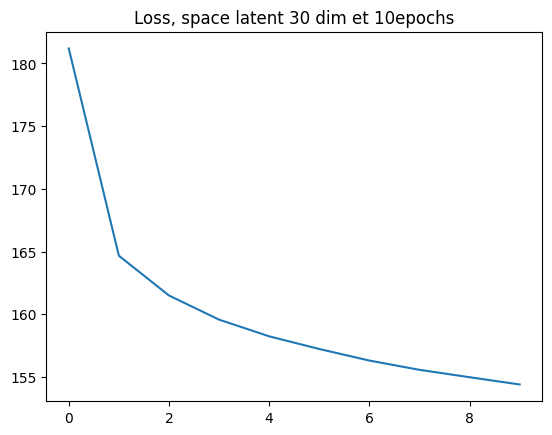

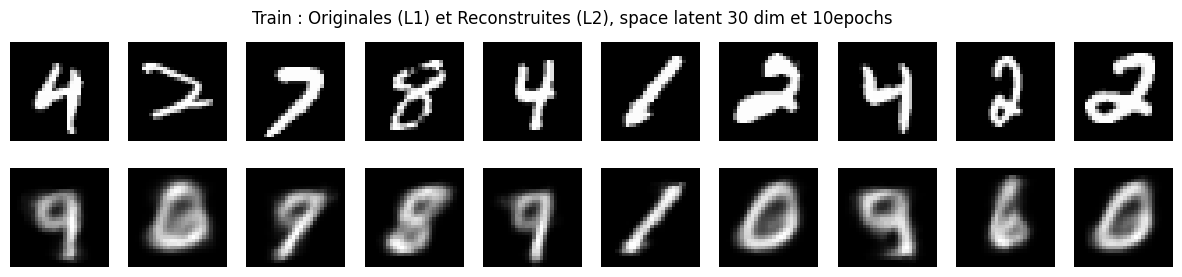

In [87]:
vae = VAE().to(device)
optimizer = optim.Adam(vae.parameters(), lr=leraning_rate)
listimg_recon = []
listimg_ori = []
courbe = []

for epoch in range(nb_epochs):
    vae.train()
    train_loss = 0
    for batch_idx, (img0, _) in enumerate(tqdm(train_loader)):
        img = img0.view(-1, 784).to(device)  # reshaping au H*W des images MNIST
        optimizer.zero_grad()
        recon_batch, mu, logvar = vae(img)
        loss = loss_function(recon_batch, img, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
    
    listimg_ori.append(img[epoch].detach().cpu().view(28, 28))
    listimg_recon.append(recon_batch[epoch].detach().cpu().view(28, 28))
    
        
    if epoch % 2 == 0:#(nb_epochs//10) == 0:
        print(f'Epoch {epoch + 1}, Loss: {train_loss / len(train_loader.dataset):.4f}')
    courbe.append(train_loss / len(train_loader.dataset))

# courbe de loss    
plt.plot(courbe)
plt.title(f'Loss, space latent {latent_dim} dim et {nb_epochs}epochs')    
plt.savefig(f"graph/loss_{latent_dim} space latent.png")
  
# comparaison des images originales et reconstruites    
fig, axes = plt.subplots(2, 10, figsize=(15, 3))
for i in range(10):
    axes[0, i].imshow(listimg_ori[i], cmap='gray')
    axes[1, i].imshow(listimg_recon[i], cmap='gray')
    axes[0, i].axis('off')
    axes[1, i].axis('off')
fig.suptitle(f'Train : Originales (L1) et Reconstruites (L2), space latent {latent_dim} dim et {nb_epochs}epochs')
plt.savefig(f"graph/train_comparison_{latent_dim} space latent.png")

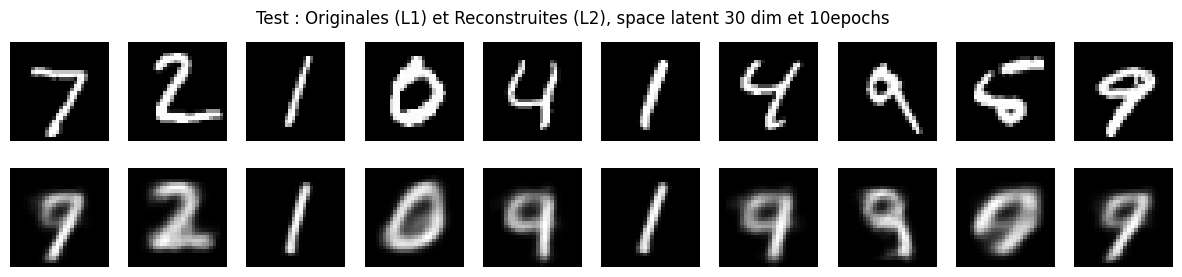

In [88]:
vae.eval()
with torch.no_grad():
    for img0, _ in test_loader:
        img = img0.view(-1, 784).to(device)
        img_recon, _, _ = vae(img)
        break

# les images originales et reconstruites
original = img.view(-1, 28, 28).cpu().numpy()
recons = img_recon.view(-1, 28, 28).cpu().numpy()

fig, axes = plt.subplots(2, 10, figsize=(15, 3))
for i in range(10):
    axes[0, i].imshow(original[i], cmap='gray')
    axes[1, i].imshow(recons[i], cmap='gray')
    axes[0, i].axis('off')
    axes[1, i].axis('off')
fig.suptitle(f'Test : Originales (L1) et Reconstruites (L2), space latent {latent_dim} dim et {nb_epochs}epochs')
plt.savefig(f"graph/test_comparison_{latent_dim} space latent.png")

fin

Exploration de l'espace latent:

Projetion des représentations latentes des images en 2D pour latent_dim = 2.

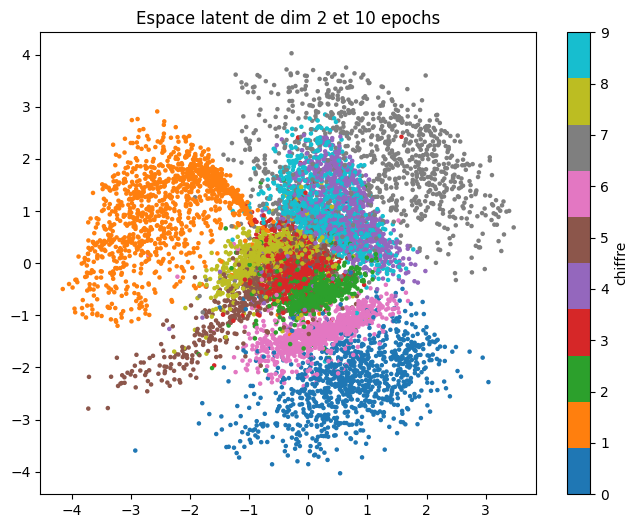

In [72]:
latent_points = []
labels = []

vae.eval()
with torch.no_grad():
    for img0, label in test_loader:
        img = img0.view(-1, 784).to(device)
        mu, _ = vae.encode(img)
        latent_points.append(mu.cpu().numpy())
        labels.append(label.numpy())

latent_points = np.concatenate(latent_points)
labels = np.concatenate(labels)

plt.figure(figsize=(8, 6))
plt.scatter(latent_points[:, 0], latent_points[:, 1], c=labels, cmap='tab10', s=5)
plt.colorbar(label='chiffre')
plt.title(f'Espace latent de dim {latent_dim} et {nb_epochs} epochs')
plt.savefig(f"graph/latent_space.png")
